In [1]:
import sys
import os
# Append the parent directory to sys.path for relative imports
project_root = dir_path = os.path.dirname(os.getcwd())
sys.path.append(project_root)

import numpy as np
import pandas as pd
import random
import scipy.sparse as sp
import tensorflow as tf
from tensorflow.keras.utils import Progbar
from src.utils import preprocess, metrics
from src import LightGCN

# Suppress warnings for cleaner notebook presentation
import warnings
warnings.simplefilter("ignore")

2024-04-07 12:14:35.465256: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-07 12:14:35.502948: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-07 12:14:35.503002: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-07 12:14:35.503034: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-07 12:14:35.510772: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-07 12:14:35.511855: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

## Dataset

In [2]:
columns = ["movieid", "title", "genre"]
movies = pd.read_table("../data/movies.dat", names = columns, sep = "::", encoding = "latin1", engine = "python")
movies

,movieid,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [3]:
columns = ['userid', 'movieid', 'rating', 'timestamp']
ratings = pd.read_table("../data/ratings.dat", names = columns, sep = "::", encoding = "latin1", engine='python')
ratings

,userid,movieid,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [14]:
ratings.describe().T

,count,mean,std,min,25%,50%,75%,max
userid,1000209.0,3024.512348,1728.412695,1.0,1506.0,3070.0,4476.0,6040.0
movieid,1000209.0,1865.539898,1096.040689,1.0,1030.0,1835.0,2770.0,3952.0
rating,1000209.0,3.581564,1.117102,1.0,3.0,4.0,4.0,5.0


In [7]:
ratings = ratings.drop('timestamp' , a)

In [4]:
columns = ['User_ID', 'Gender', 'Age', 'Occupation', 'Zip-code']
users = pd.read_table("../data/users.dat", names = columns, sep = "::", encoding = "latin1", engine='python')
users

,User_ID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
...,...,...,...,...,...
6035,6036,F,25,15,32603
6036,6037,F,45,1,76006
6037,6038,F,56,1,14706
6038,6039,F,45,0,01060


### Train Test Split

In [8]:
# Split data into training and testing sets
train_size = 0.75
train, test = preprocess.stratified_split(ratings, 'userid', train_size)
print(f'Train Shape: {train.shape}\nTest Shape: {test.shape}')
print(f'Do they have the same users?: {set(train.userid) == set(test.userid)}')


Train Shape: (750121, 3)
Test Shape: (250088, 3)
Do they have the same users?: True


In [28]:
# Assuming train and test DataFrames are already defined
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

# Combine train and test data
combined = pd.concat([train, test]).reset_index(drop=True)

# Count unique users and movies
n_users = combined['userid'].max()
n_movies = combined['movieid'].max()
print('Number of users:', n_users)
print('Number of movies:', n_movies)

# Create user and item mappings
user2id = {uid: idx for idx, uid in enumerate(combined['userid'].unique())}
book2id = {book: idx for idx, book in enumerate(combined['movieid'].unique())}
id2user = {idx: uid for uid, idx in user2id.items()}
id2item = {idx: book for book, idx in book2id.items()}

# Apply mappings to train and test sets
train['user_id_new'] = train['userid'].map(user2id)
train['movie_id_new'] = train['movieid'].map(book2id)
test['user_id_new'] = test['userid'].map(user2id)
test['movie_id_new'] = test['movieid'].map(book2id)


# Check for NaNs after reindexing
print("NaNs in train_reindex user_id:", train['user_id_new'].isna().sum())
print("NaNs in test_reindex user_id:", test['user_id_new'].isna().sum())

# Create a DataFrame to keep track of which books each user has interacted with
interacted = train.groupby("user_id_new")["movie_id_new"].apply(set).reset_index()
interacted.rename(columns={"movie_id_new": "movie_interacted"}, inplace=True)

Number of users: 6040
Number of movies: 3952
NaNs in train_reindex user_id: 0
NaNs in test_reindex user_id: 0


In [24]:
interacted

,userid,movie_interacted
0,1,"{1, 2692, 260, 1029, 1287, 1035, 527, 783, 232..."
1,2,"{1544, 2571, 1552, 2067, 21, 3105, 3107, 3108,..."
2,3,"{1291, 653, 1431, 2081, 3619, 552, 1961, 3114,..."
3,4,"{480, 2366, 2692, 260, 3527, 1210, 1097, 1387,..."
4,5,"{2560, 6, 3079, 3081, 2058, 2571, 16, 1554, 25..."
...,...,...
6035,6036,"{2048, 4, 6, 2058, 11, 16, 21, 2070, 2071, 24,..."
6036,6037,"{916, 2571, 2064, 17, 2065, 3095, 541, 34, 157..."
6037,6038,"{2146, 356, 1223, 232, 1354, 1419, 1387, 2700,..."
6038,6039,"{3072, 1028, 2565, 3088, 2067, 2080, 2083, 208..."


### Adjacency matrix

The adjacency matrix is a data structure the represents a graph by encoding the connections and between nodes. In our case, nodes are both users and movies. Rows and columns consist of ALL the nodes and for every connection (reviewed movie) there is the value 1.

To first create the adjacency matrix we first create a user-item graph where similar to the adjacency matrix, connected users and movies are represented as 1 in a sparse array. Unlike the adjacency matrix, a user-item graph only has users for the columns/rows and items as the other, whereas the adjacency matrix has both users and items concatenated as rows and columns.

In this case, because the graph is undirected (meaning the connections between nodes do not have a specified direction) the adjacency matrix is symmetric. We use this to our advantage by transposing the user-item graph to create the adjacency matrix.

Our adjacency matrix will not include self-connections where each node is connected to itself.

In [30]:
# Create user-item interaction matrix
R = sp.dok_matrix((n_users, n_movies), dtype=np.float32)
for _, row in train.iterrows():
    R[row['user_id_new'], row['movie_id_new']] = 1

# Create adjacency matrix
adj_mat = sp.dok_matrix((n_users + n_movies, n_users + n_movies), dtype=np.float32)
adj_mat[:n_users, n_users:] = R
adj_mat[n_users:, :n_users] = R.T

In [31]:
# Calculate normalized adjacency matrix
D_values = np.array(adj_mat.sum(1))
D_inv_values = np.power(D_values + 1e-9, -0.5).flatten()
D_inv_values[np.isinf(D_inv_values)] = 0.0
D_inv_sq_root = sp.diags(D_inv_values)
norm_adj_mat = D_inv_sq_root.dot(adj_mat).dot(D_inv_sq_root)

In [32]:
# Convert to SparseTensor for TensorFlow
coo = norm_adj_mat.tocoo().astype(np.float32)
indices = np.mat([coo.row, coo.col]).transpose()
A_tilde = tf.SparseTensor(indices, coo.data, coo.shape)

2024-04-07 12:55:01.532883: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-07 12:55:02.073631: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-04-07 12:55:02.412452: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 24003872 exceeds 10% of free system memory.



## Model : _LightGCN_

LightGCN keeps neighbor aggregation while removing self-connections, feature transformation, and nonlinear activation, simplifying as well as improving performance.

Neighbor aggregation is done through graph convolutions to learn embeddings that represent nodes. The size of the embeddings can be changed to whatever number. In this notebook, we set the embedding dimension to 64.

In matrix form, graph convolution can be thought of as matrix multiplication. In the implementation we create a graph convolution layer that performs just this, allowing us to stack as many graph convolutions as we want. We have the number of layers as 10 in this notebook.
Custom training

For training, we batch a number of users from the training set and sample a single positive item (movie that has been reviewed) and a single negative item (movie that has not been reviewed) for each user.

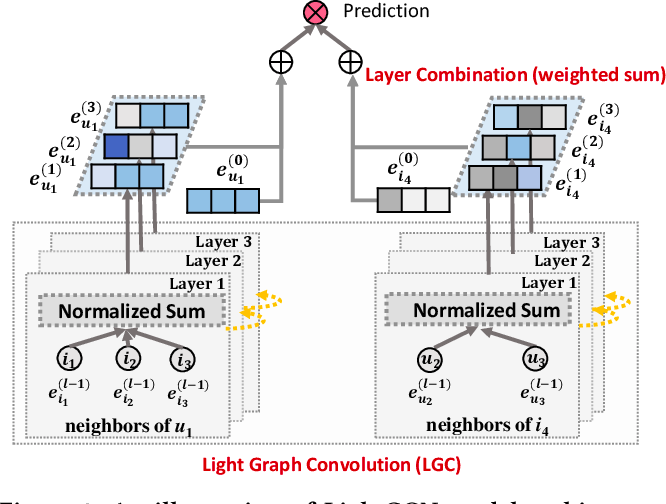

In [33]:
# Model configuration
N_LAYERS = 10
EMBED_DIM = 64
DECAY = 0.0001
EPOCHS = 200
BATCH_SIZE = 1024
LEARNING_RATE = 1e-2

# Initialize LightGCN model
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model = LightGCN.LightGCN(A_tilde, n_users, n_movies, N_LAYERS, EMBED_DIM, DECAY)

2024-04-07 12:56:21.961881: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 399360256 exceeds 10% of free system memory.
2024-04-07 12:56:22.353820: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 95480320 exceeds 10% of free system memory.


In [ ]:
%%time
# # Custom training loop with negative sampling and gradient updates
for epoch in range(1, EPOCHS + 1):
    print(f'Epoch {epoch}/{EPOCHS}')
    n_batch = len(train) // BATCH_SIZE + (len(train) % BATCH_SIZE != 0)
    bar = Progbar(n_batch)
    
    for _ in range(n_batch):
        # Sample a batch of users
        users = np.random.choice(n_users, BATCH_SIZE, replace=False)

        # Function for negative sampling
        def sample_neg(user_interacted_items):
            while True:
                neg_item = random.randint(0, n_movies - 1)
                if neg_item not in user_interacted_items:
                    return neg_item

        # Sample positive and negative items for each user
        pos_items = [random.choice(list(interacted[interacted['user_id_new'] == u]['movie_interacted'].values[0])) for u in users]
        neg_items = [sample_neg(interacted[interacted['user_id_new'] == u]['movie_interacted'].values[0]) for u in users]

        with tf.GradientTape() as tape:
            # Call LightGCN with user and item embeddings
            new_user_embeddings, new_item_embeddings = model(
                (model.user_embedding, model.item_embedding)
            )

            # Embeddings after convolutions
            user_embeddings = tf.nn.embedding_lookup(new_user_embeddings, users)
            pos_item_embeddings = tf.nn.embedding_lookup(new_item_embeddings, pos_items)
            neg_item_embeddings = tf.nn.embedding_lookup(new_item_embeddings, neg_items)

            # Initial embeddings before convolutions
            old_user_embeddings = tf.nn.embedding_lookup(model.user_embedding, users)
            old_pos_item_embeddings = tf.nn.embedding_lookup(model.item_embedding, pos_items)
            old_neg_item_embeddings = tf.nn.embedding_lookup(model.item_embedding, neg_items)

            # Calculate loss
            pos_scores = tf.reduce_sum(tf.multiply(user_embeddings, pos_item_embeddings), axis=1)
            neg_scores = tf.reduce_sum(tf.multiply(user_embeddings, neg_item_embeddings), axis=1)
            regularizer = (tf.nn.l2_loss(old_user_embeddings) +
                           tf.nn.l2_loss(old_pos_item_embeddings) +
                           tf.nn.l2_loss(old_neg_item_embeddings)) / BATCH_SIZE
            mf_loss = tf.reduce_mean(tf.nn.softplus(-(pos_scores - neg_scores)))
            emb_loss = DECAY * regularizer
            loss = mf_loss + emb_loss

        # Apply gradients
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        bar.add(1, values=[('training loss', float(loss))])


Epoch 1/200


2024-04-07 12:58:32.044407: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 28137472 exceeds 10% of free system memory.
2024-04-07 12:58:32.196930: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 28137472 exceeds 10% of free system memory.


733/733 [==============================] - 2309s 3s/step - training loss: 0.3381
Epoch 2/200
733/733 [==============================] - 2311s 3s/step - training loss: 0.2946
Epoch 3/200
733/733 [==============================] - 2306s 3s/step - training loss: 0.2657
Epoch 4/200
733/733 [==============================] - 3337s 5s/step - training loss: 0.2445
Epoch 5/200
 48/733 [>.............................] - ETA: 40:24:36 - training loss: 0.2344